# YOLO(You Only Look Once)
- grid-wise하게 detection하는 것이 일종의 constrainsts가 되어 각가의. detector가 특화 될 수 있으면, 이것이 detection에서 굉장히 중ㅇㅛ한 부분이라는 것.

In [ ]:
 YOLO, SSD, SqueezeDet, and DetectNet.

## Object Detection
- Object detection은 classification보다 더 많이 발전 되다.
- object detection 모델은 bounding boxes(Localization)과 classification을 예측하는 것이다.
    - 두가지를 동시에 하면 one_stage_object_detection이라고 함
    - 각각 한가지씩 하면 two_stage_object_detection이라고 함 
- 보통 매우 많은 bounding box들을 친다. 
- 각각의 bounding box는 confidence score을 가진다.->confidence score는 그 box가 정말로 물체를 포함할 거 같은 가에 대한 점수이다.
- 마지막 후처리과정에서 특정 threshold 값 아래의 confidence score을 가진 box들을 없애준다(non-maximum suppression)

- One of the problems you’ll encounter is that a training image can have anywhere from zero to dozens of objects in them, 

- loss function
    - cross-entropy : claasification
    - mean-squared-error : localization
    
- IOU 
    - Intersection-Over-Union
    - 교집합 영역 넓이 / 합집합 영역 넓이

 box confidence score는 box가 객체를 포함하고 있을 가능성(objectness)과 boundary box가 얼마나 정확한지를 반영
 ![](https://miro.medium.com/max/700/1*0IPktA65WxOBfP_ULQWcmw.png)

It’s much harder for a machine learning model to learn about images if we only use plain FC layers. The constraints imposed upon the convolutional layer — it looks only at a few pixels at a time, and the connections share the same weights — help the model to extract knowledge from images. We use these constraints to remove degrees of freedom and to guide the model into learning what we want it to learn.

Likewise, the grid forces the model to learn object detectors that specialize in specific locations.

- ground-truth boxes = annotation
- class probabilities = classification_num
- confidence = object-ness

### IOU 구현해보기

In [1]:
import numpy as np
import matplotlib.pyplot as plt

1


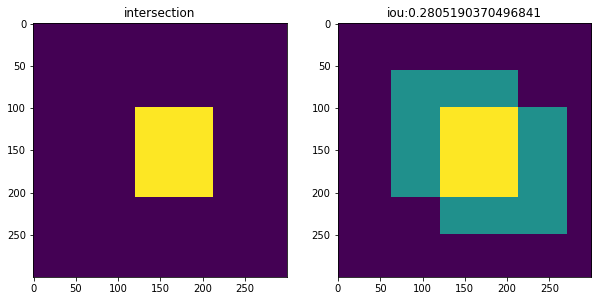

In [4]:
a_image = np.ones((150,150))
b_image = np.ones((150,150))

frame = np.zeros((300,300))
random_w = np.random.randint(0,150)
random_h = np.random.randint(0,150)
ax_min = random_w
ax_max = random_w+150
ay_min = random_h
ay_max = random_h+150

frame[ay_min:ay_max,ax_min:ax_max] +=a_image

random_w = np.random.randint(0,150)
random_h = np.random.randint(0,150)
bx_min = random_w
bx_max = random_w+150
by_min = random_h
by_max = random_h+150

frame[by_min:by_max,bx_min:bx_max] += b_image
copy_frame = np.zeros((300,300))
iou = 0
if(ax_min < bx_min):
    if(ay_min < by_min):
        if(bx_min < ax_max and by_min < ay_max):
            print('1')
            copy_frame[by_min:ay_max,bx_min:ax_max] = np.ones((ay_max-by_min,ax_max-bx_min))
            
            intersection = (ay_max-by_min)*(ax_max-bx_min)
            union = 150*150 + 150*150 - intersection
            iou = intersection/union
            
    elif(ay_min > by_min):
        if(bx_min < ax_max and ay_min < by_max):
            print('2')
            copy_frame[ay_min:by_max,bx_min:ax_max] = np.ones((by_max-ay_min,ax_max-bx_min))
            
            intersection = (by_max-ay_min)*(ax_max-bx_min)
            union = 150*150 + 150*150 - intersection
            iou = intersection/union

elif(ax_min > bx_min):
    if(ay_min < by_min):
        if(ax_min < bx_max and by_min < ay_max):
            print('3')
            copy_frame[by_min:ay_max,ax_min:bx_max] = np.ones((ay_max-by_min,bx_max-ax_min))
            
            intersection = (ay_max-by_min)*(bx_max-ax_min)
            union = 150*150 + 150*150 - intersection
            iou = intersection/union
            
    elif(ay_min > by_min):
        if(ax_min < bx_max and ay_min < by_max):
            print('4')
            copy_frame[ay_min:by_max,ax_min:bx_max] = np.ones((by_max-ay_min,bx_max-ax_min))
            
            intersection = (by_max-ay_min)*(bx_max-ax_min)
            union = 150*150 + 150*150 - intersection
            iou = intersection/union

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("intersection")
plt.imshow(copy_frame)
plt.subplot(1,2,2)
plt.title("intersection")
plt.title("iou:"+str(iou))
plt.imshow(frame)
plt.show()


In [5]:
def get_iou(b1, b2, epsilon=1e-5):
    """ Given two boxes `a` and `b` defined as a list of four numbers:
            [center_x,center_y,width,height]
 
    Returns:
        (float) The Intersect of Union score.
    """
    
    # The Area Of Intersect
    intersect_width  = min(b1[2],b2[2])
    
    intersect_height = min(b1[3],b2[3])
    
    
    intersect_area = intersect_width * intersect_height
    
    # The Area Of Union
    b1_area = b1[2] * b1[3]
    b2_area = b2[2] * b2[3]
    
    union_area = b1_area + b2_area - intersect_area
    
 
    # Intersection Of Union
    iou = intersect_area / (union_area+epsilon)
    return iou

### Machine is Stupid
regresion으로 하나의 bounding box을 예측하는 것은 좋은 결과를 준다. 하지만 분류의 문제와 같이, 이미지에 2개 이상의 물체가 있으면 잘 동작하지 않는다. 그 이유는 기존 4개의 regression(sigmoid)한 값을 출력하는 것은 하나의 bounding box을 예측하는 것이다. 그래서 만약 2개 이상의 관심 대상이 있을 때 둘 중 하나를 골라야 된다. 하지만, 모델은 (생각이 없어서) 실제로 둘 중 하나를 고르지 않고 밑에 그림처럼 중간의 어느 위치가 될 것이다. 
![](https://machinethink.net/images/object-detection/localization-1box-bad.jpg)

그럼 두개 이상의 bounding box 예측기를 추가하면 어떨까? 잘 실행되어 두 개이상의 물체를 잘 bounding해줄까? 그렇지 않다. 밑에 처럼 중앙에 bounding box들이 처질 것이다. 왜 그런 것일까? 왜냐하면 모델은 어떤 바운딩 박스가 어떤 물체에 할당 되어야 되는 지 알지 못한다. 각각의 예측기는 모든 물체가 가능한 위치를 예측하려고 한다. 그래서 모델은 중간에 놓려고 할 것이다. 사실상 모델에게 무리한 요구 인것이다. **각각의 예측기는 하나를 대상으로 bounding 치려고 하지 않고 두 물체에 대해서 bounding 치려고 할 것이다. 그래서 중앙에 놓이게 된다.** 문제를 해결하기 위해서 **각각의 예측기가 이미지의 특정한 위치에 전문화(고정) 되도록 학습할 필요가 있다.**
![](https://machinethink.net/images/object-detection/localization-2box-bad.jpg)

보통 multi-classification을 할때는 softmax를 하지만, detection에서는 boundingbox와 독립적으로 수행되기 때문에 sigmoid를 사용한다.

confidence score: 예측된 bounding box가 진짜 물체를 포함하고 있는지를 나타냄(0~1), object-ness라고도 함, 오직 물체가 있는지 없는지만 말해줌, object연산에 사용됨(iou)

### Constraints are good
13x13 grid는 일종의 부분적 제약(spatial constraint)이다. 이러한 제약은 모델이 bouding box를 보다 쉽게 예측하도록 한다. convolution layer도 그자체로 fully-connected layer의 제약 버전이다. fully-connected layer는 모든 픽셀에 대해서 weight를 취하지만 convolution layer는 특정 맵만 사용하여 한 channel에 대해서 weight를 공유한다(contraint).**constraints(제약)은 모델이 이미지로 부터 지식을 추출하도록 돕는다.** 여기서 **13x13 grid constraints는 자유로움의 정도를 제거하고 우리가 원하는 모델이 되도록 학습 되게 한다.**

### anchors
anchor는 물체의 형태를 제약하는 것이다. 한 cell에서 하나의 detector만으로 어떤 형태(bouding box)을 가질 수 있는 물체를 예측하는 건 매우 어렵다.
- anchor들은 cell안에 있는 detector들이 각각 특정 오브젝트 shape에 대해서 전문화 되도록 한다.
- 대략 평균 anchor 리스트
![](https://machinethink.net/images/object-detection/anchors.png)
- 위의 그림처럼 각각의 anchor box들은 사전에 골라진다. -> 그것들은 훈련하는 동안 불변한다.
- bias라고도 함 -> anchor들의 값은 detector이 물체의 특정한 shape를 예측하도록 편중(biased)되어진다.
- anchor 리스트는 모든 train의 bounding box(annotation)에 대해서 k-mean-clustering으로 구현되어 고정된다.


- anchor박스를 많이 할수록 iou가 1에 가까워진다. 밑에 그림을 참조
![](https://machinethink.net/images/object-detection/number-of-centroids.png)

### K mean Clustering
![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile4.uf.tistory.com%2Fimage%2F9909223C5AC63A891F05F1)
- 데이터를 입력받아 이를 소수의 그룹으로 묶는 알고리즘
- 비지도 학습(label이 없는 데이터)
- loss_function
$${argmin_{r,c}\sum^N_{n=1}\sum^K_{k=1}r_{nk}{||x_n - c_k||}^2}$$

### K Mean Clustering 구현해보기

In [6]:
# default
x = np.array([1,6,7,3,6,2,2])
y = np.array([1,6,7,2,8,1,3])

c1 = np.array([4.0,3.0])
c2 = np.array([7.0,9.0])

In [7]:
def k_mean_clustering(x,y, c1,c2, iteration):
    # K Mean Clustering
    for i in range(iteration):
    
        c1_l2 = np.sqrt(((x-c1[0])**2 + (y-c1[1])**2))
        c2_l2 = np.sqrt(((x-c2[0])**2 + (y-c2[1])**2))
        r1_x = []
        r1_y = []
        r2_x = []
        r2_y = []
        for i in range(len(c1_l2)):
            if(c1_l2[i] > c2_l2[i]):
                r2_x.append(x[i])
                r2_y.append(y[i])
            if(c1_l2[i] < c2_l2[i]):
                r1_x.append(x[i])
                r1_y.append(y[i])
        previous_c1 = c1.copy()
        previous_c2 = c2.copy()

        c1[0] = (1/len(r1_x))*(np.sum(r1_x))
        c1[1] = (1/len(r1_y))*(np.sum(r1_y))

        c2[0] = (1/len(r2_x))*(np.sum(r2_x))
        c2[1] = (1/len(r2_y))*(np.sum(r2_y))


        if((np.sum(previous_c1 == c1)==2) and (np.sum(previous_c2 == c2)==2)):
            break
    return c1, c2

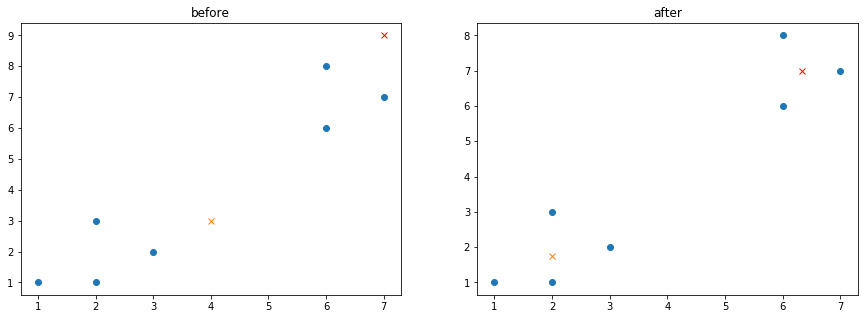

In [8]:
# visualization
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("before")
plt.plot(x,y,'o')
plt.plot(c1[0],c1[1],'x',)
plt.plot(c2[0],c2[1],'xr')


# K Mean Clustering
c1, c2 = k_mean_clustering(x,y,c1,c2,3)
    
# visualization
plt.subplot(1,2,2)
plt.title("after")
plt.plot(x,y,'o')
plt.plot(c1[0],c1[1],'x',)
plt.plot(c2[0],c2[1],'xr')
plt.show()

In [9]:
w = np.concatenate((np.random.uniform(0,10,10),np.random.uniform(10,20,10)))
h = np.concatenate((np.random.uniform(0,10,10),np.random.uniform(10,20,10)))

a1 = np.random.uniform(0,20,30)
a2 = np.random.uniform(0,20,30)

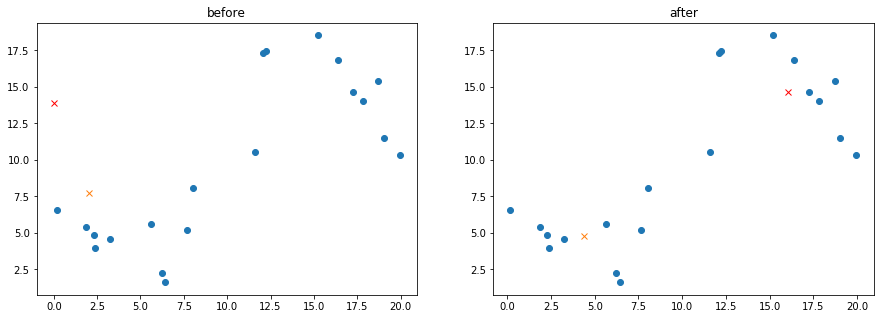

In [10]:
# visualization
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("before")
plt.plot(w,h,'o')
plt.plot(a1[0],a1[1],'x',)
plt.plot(a2[0],a2[1],'xr')


# K Mean Clustering
a1, a2 = k_mean_clustering(w,h,a1,a2,30)
    
# visualization
plt.subplot(1,2,2)
plt.title("after")
plt.plot(w,h,'o')
plt.plot(a1[0],a1[1],'x',)
plt.plot(a2[0],a2[1],'xr')
plt.show()

In [2]:
import os
import json

In [3]:
annotation_path = "/Users/changmin.kim/Downloads/face_with_mask_detection/Medical_mask/Medical_mask/Medical_Mask/annotations/"

In [4]:
image_path = "/Users/changmin.kim/Downloads/face_with_mask_detection/Medical_mask/Medical_mask/Medical_Mask/images/"

In [5]:
annotation_list = os.listdir(annotation_path)

In [6]:
len(annotation_list)

4326

In [7]:
try:
    annotation_list.remove('.DS_Store')
except Exception as e:
    print("Not ('.DS_Store'")

Not ('.DS_Store'


In [8]:
annotation_list.sort()

In [9]:
import cv2

In [10]:
json_datas = []
image_datas = []
max_num = 0
for i in range(len(annotation_list)):
    with open(os.path.join(annotation_path,annotation_list[i]),"r") as json_file:
        json_data = json.load(json_file)
        
    length = len(json_data.get("Annotations"))
    count = 0
    for j in range(length):
        name = json_data['Annotations'][j]['classname']
        if(name[:4]=="face"):
            count +=1
        
        if(count > 3):
            break
    if(count <= 3):
        json_datas.append(json_data)
        
        test_image = cv2.imread(image_path+json_data['FileName'])
        test_image = cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
        
        image_datas.append(test_image)
    if(i%200==0):
        print(".",end=' ')

. . . . . . . . . . . . . . . . . . . . . . 

In [20]:
## anchor 
anchors_w = []
anchors_h = []
for i in range(len(json_datas)):
    annotaions = json_datas[i]['Annotations']
    image_size = image_datas[i].shape
    for j in range(len(annotaions)):
        boudingBox = annotaions[0]["BoundingBox"]
        width = ((boudingBox[2] - boudingBox[0])/image_size[1])*IMAGE_SIZE
        anchors_w.append(width)
        height = ((boudingBox[3] - boudingBox[1])/image_size[0])*IMAGE_SIZE
        anchors_h.append(height)

NameError: name 'IMAGE_SIZE' is not defined

In [21]:
def processing(images, json_data_list, re_size=416):
    preprocessing_xData = []
    preprocessing_yData = []
    for i in range(len(json_data_list)):
        test_image = images[i]
        image_size = test_image.shape
        

        while True:
            shape = test_image.shape[:2]
            if(int(shape[0]/2)<=re_size or int(shape[1]/2)<=re_size):
                test_image = cv2.resize(test_image,(re_size,re_size))
                break
            test_image = cv2.resize(test_image,(int(shape[0]/2),int(shape[1]/2)))
        preprocessing_xData.append(test_image)
            
        
        label = []
        annotaions = json_data_list[i]['Annotations']
        position = np.zeros(169)
        
        indexs = []
        for j in range(len(annotaions)):
            name = annotaions[j]['classname'][:4]
            if name=="face":
                boudingBox = annotaions[j]["BoundingBox"]
                xmin = boudingBox[0]
                ymin = boudingBox[1]
                xmax = boudingBox[2]
                ymax = boudingBox[3]

                delta_x = (((xmax+xmin)/2)/image_size[1])*re_size
                delta_y = (((ymax+ymin)/2)/image_size[0])*re_size

                width = ((xmax - xmin)/image_size[1])*re_size
                height = ((ymax - ymin)/image_size[0])*re_size

                row = int(delta_y/32)
                column = int(delta_x/32)
                index = row*13 + (column+1) -1

                if len(indexs)>0:
                    check = 0
                    for v in range(len(indexs)):
                        if(index == indexs[v]):
                            check = 1
                    if(check==0):
                        position[index] = 1
                        label.append([delta_x])
                        label.append([delta_y])
                        label.append([width])
                        label.append([height])
                        indexs.append(index)

                else:
                    position[index] = 1
                    label.append([delta_x])
                    label.append([delta_y])
                    label.append([width])
                    label.append([height])
                    indexs.append(index)
            
        for j in range(3-len(indexs)):
            label.append([0,0,0,0])
        label.append(position)
        label = np.concatenate(label)
        
        preprocessing_yData.append(label)
        
        if(i%200 ==0):
            print(".",end=" ")
        
        
    preprocessing_xData = np.array(preprocessing_xData)
    preprocessing_yData = np.array(preprocessing_yData)
    
    
    return (preprocessing_xData, preprocessing_yData)

In [11]:
def processing(images, json_data_list, re_size=416):
    preprocessing_xData = []
    preprocessing_yData = []
    for i in range(len(json_data_list)):
        
        # initial_value
        test_image = images[i]
        image_size = test_image.shape
        
        # resizing image
        while True:
            shape = test_image.shape[:2]
            if(int(shape[0]/2)<=re_size or int(shape[1]/2)<=re_size):
                test_image = cv2.resize(test_image,(re_size,re_size))
                break
            test_image = cv2.resize(test_image,(int(shape[0]/2),int(shape[1]/2)))
        preprocessing_xData.append(test_image)
            
        
        # bounding label
        annotaions = json_data_list[i]['Annotations']

        
        indexs = []
        element = np.zeros((1,13,13,6))
        for j in range(len(annotaions)):
            name = annotaions[j]['classname']
            if name[:4]=="face":
                boudingBox = annotaions[j]["BoundingBox"]
                xmin = boudingBox[0]
                ymin = boudingBox[1]
                xmax = boudingBox[2]
                ymax = boudingBox[3]

                delta_x = (((xmax+xmin)/2)/image_size[1])*re_size
                delta_y = (((ymax+ymin)/2)/image_size[0])*re_size

                width = ((xmax - xmin)/image_size[1])*re_size
                height = ((ymax - ymin)/image_size[0])*re_size
                
                classes = 0     
                if (name[:14]=="face_with_mask"):
                    classes = 1 # with mask
                else:
                    classes = 0 # with no mask

                row = int(delta_y/32)
                column = int(delta_x/32)
                index = row*13 + (column+1) -1

                if len(indexs)>0:
                    check = 0
                    for v in range(len(indexs)):
                        if(index == indexs[v]):
                            check = 1
                            
                    if(check==0):
                        element[0,row, column, 0] = 1        # confidence
                        element[0,row, column, 1] = delta_x  # bx(center)
                        element[0,row, column, 2] = delta_y  # by(center)
                        element[0,row, column, 3] = width    # bw
                        element[0,row, column, 4] = height   # bh
                        element[0,row, column, 5] = classes  # class
                        
                        indexs.append(index)

                else:
                    element[0,row, column, 0] = 1        # confidence
                    element[0,row, column, 1] = delta_x  # bx(center)
                    element[0,row, column, 2] = delta_y  # by(center)
                    element[0,row, column, 3] = width    # bw
                    element[0,row, column, 4] = height   # bh
                    element[0,row, column, 5] = classes  # class

                    indexs.append(index)
                
        
        preprocessing_yData.append(element)
        
        if(i%200 ==0):
            print(".",end=" ")
        
        
    preprocessing_xData = np.array(preprocessing_xData)
    preprocessing_yData = np.concatenate(preprocessing_yData)
    
    
    return (preprocessing_xData, preprocessing_yData)

In [12]:
preprocessing_xData, preprocessing_yData = processing(image_datas,json_datas)

. . . . . . . . . . . . . . . . . . . . 

In [13]:
np.save('/Users/changmin.kim/Downloads/preprocessing_xData.npy',preprocessing_xData,allow_pickle=True)

In [14]:
np.save('/Users/changmin.kim/Downloads/preprocessing_yData.npy',preprocessing_yData,allow_pickle=True)

In [28]:
from matplotlib.patches import Rectangle

In [29]:
# visualization
def visualization():
    num = np.random.randint(len(preprocessing_yData))
    plt.imshow(preprocessing_xData[num])
    position = preprocessing_yData[num][:12]
    for i in range(3):
        rect = Rectangle(( (position[4*i+0]-position[4*i+2]/2), (position[4*i+1]-position[4*i+3]/2) ), position[4*i+2],position[4*i+3],fill=False,color="red")
        plt.axes().add_patch(rect)
    plt.show()

In [30]:
# visualization
def visualization():
    fig, axs = plt.subplots(1, 6, figsize=(15, 3), sharey=True)
    num = np.random.randint(0,len(preprocessing_yData),6)

    for j in range(6):
        number = num[j]
        confidence = preprocessing_yData[number][:,:,0]

        position = np.where(confidence==1)
        bounding_box = preprocessing_yData[number][:,:,1:5]

        axs[j].imshow(preprocessing_xData[number])
        if(len(position[0])==1):
            column = position[1]
            row = position[0]

            bx = bounding_box[row,column,0]
            by = bounding_box[row,column,1]
            bw = bounding_box[row,column,2]
            bh = bounding_box[row,column,3]


            bxmin = bx - bw/2
            bymin = by - bh/2

            rect = Rectangle((bxmin, bymin), bw,bh,fill=False,color="red")
            axs[j].add_patch(rect)

        else:
            for v in range(len(position[0])):

                row = position[0][v]
                column = position[1][v]

                bx = bounding_box[row,column,0]
                by = bounding_box[row,column,1]
                bw = bounding_box[row,column,2]
                bh = bounding_box[row,column,3]


                bxmin = bx - bw/2
                bymin = by - bh/2


                rect = Rectangle((bxmin, bymin), bw,bh,fill=False,color="red",)
                axs[j].add_patch(rect)

    fig.suptitle('Bounding And Confidence')
    plt.show()
    fig, axs = plt.subplots(1, 6, figsize=(15, 5), sharey=True)
    for i in range(6):
        number = num[i]
        confidence = preprocessing_yData[number][:,:,0]
        axs[i].imshow(confidence)
    plt.show()

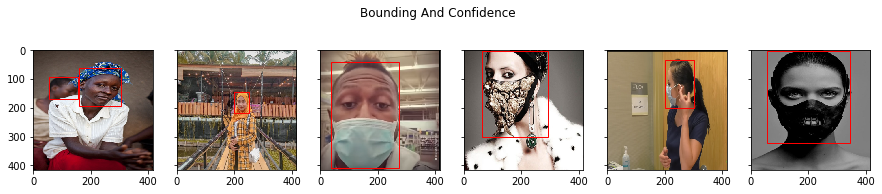

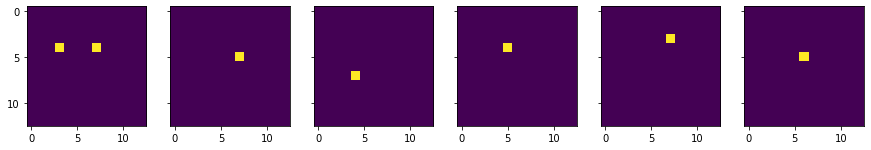

In [31]:
visualization()

In [32]:
from sklearn.cluster import KMeans

In [33]:
anchors_w = preprocessing_yData[:,2:4][:,0]
anchors_h = preprocessing_yData[:,2:4][:,1]

In [34]:
anchors_w = []
anchors_h = []
index = np.where(preprocessing_yData[:,:,:,0]!=0)
for i in range(len(index[0])):
    w = preprocessing_yData[index[0][i], index[1][i], index[2][i],3]
    h = preprocessing_yData[index[0][i], index[1][i], index[2][i],4]
    
    anchors_w.append(w)
    anchors_h.append(h)

In [35]:
k_mean_model = KMeans(n_clusters=4).fit(np.transpose(np.array([anchors_w,anchors_h]),axes=[1,0]))

In [36]:
k_means = k_mean_model.cluster_centers_

In [37]:
k_means

array([[276.46709904, 351.85270211],
       [ 52.87250472,  81.10334548],
       [106.59493947, 170.54810571],
       [181.4208717 , 266.35600361]])

/Users/changmin.kim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


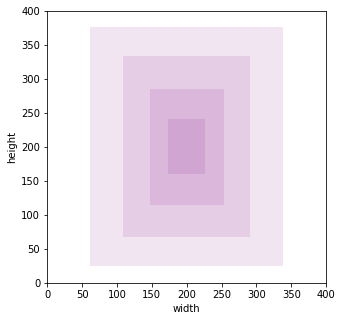

In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.figure(figsize=(5,5))
plt.xlabel('width')
plt.ylabel('height')
for i in range(len(k_means)):
    plt.axes().add_patch(
        patches.Rectangle(
            (200-(k_means[i][0]/2),200-(k_means[i][1]/2)),   # (x,y)
            k_means[i][0],          # width
            k_means[i][1],          # height
            facecolor="purple",
            alpha=0.1
        )
    )
    plt.xlim([0,400])
    plt.ylim([0,400])

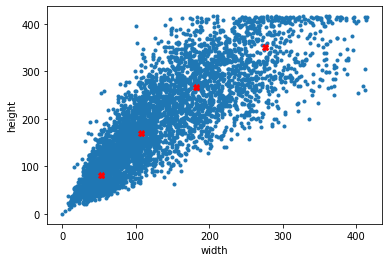

In [39]:
plt.plot(anchors_w,anchors_h,'.')
plt.xlabel('width')
plt.ylabel('height')
plt.plot(k_means[0][0],k_means[0][1],'Xr',)
plt.plot(k_means[1][0],k_means[1][1],'Xr',)
plt.plot(k_means[2][0],k_means[2][1],'Xr',)
plt.plot(k_means[3][0],k_means[3][1],'Xr',)

plt.show()

## LOSS
___
- Grid cell의 여러 bounding box들 중, ground-truth box와 의. iou와의 iou가 가장 높은 bounding box를 predictor로 설정한다.
- iou가 적어도 0.6 이상이여야 bounding box와 ground-truth와 관련 있다고 본다.
![](https://curt-park.github.io/images/yolo/lossFunction.JPG)
- (1): Object가 존재하는 grid cell i의 predictor bounding box j에 대해, x와 y의 loss를 계산. 
- (2): Object가 존재하는 grid cell i의 predictor bounding box j에 대해, w와 h의 loss를 계산.
    - 큰 box에 대해서는 small deviation을 반영하기 위해 제곱근을 취한 후, sum-squared error를 한다.
    - 같은 error라도 larger box의 경우 상대적으로 IOU에 영향을 적게 준다.
    - 제곱근을 취하지 않으면  상대적으로 loss는 큰 박스 위주로 학습하기 때문에 작은 박스는 신경을 안쓰게 될 수 있다.
        - ex) sqrt(300) -> 17 , sqrt(200) -> 14 
- (3): Object가 존재하는 grid cell i의 predictor bounding box j에 대해, confidence score의 loss를 계산. (Ci = 1) 
- (4): Object가 존재하지 않는 grid cell i의 bounding box j에 대해, confidence score의 loss를 계산. (Ci = 0) 
- (5): Object가 존재하는 grid cell i에 대해, conditional class probability의 loss 계산 
___

___
s: size(row 또는 column의 크기)
i: cell의 인덱스
j: bouding box predictor의 index
![](https://curt-park.github.io/images/yolo/notation.JPG)
> (1): Object가 존재하는 grid cell i의 predictor bounding box j (iou >= 0.6) <br>
> (2): Object가 존재하지 않는 grid cell i의 bounding box j (iou < 0.6) <br>
> (3): Object가 존재하는 grid cell i <br>

λcoord: 
- coordinates(x,y,w,h)에 대한 loss와 다른 loss들과의 균형을 위한 balancing parameter.
- 5

λnoobj:
- obj가 있는 box와 없는 box간에 균형을 위한 balancing parameter.
- 일반적으로 image내에는 obj가 있는 cell보다는 obj가 없는 cell이 훨씬 많으므로 모델은 오직 no obj에 대해서만 학습 하는 경향이 생긴다.
- 0.5
___


### Detectors with no ground-truth (negative examples)
$${noobject_loss[i, j, b] = noobjectscale * (0 - sigmoid(predconf[i, j, b]))^2}$$

find their object or when they misclassify the object. There are three separate loss terms that deal with this

### Detectors with a ground-truth (positive examples)

#### Confidence score
object_loss[i, j, b] = object_scale * 
         (IOU(truth_coords, pred_coords) - sigmoid(pred_conf[i, j, b]))**2

The predicted confidence score pred_conf[i, j, b] is supposed to represent the IOU between the predicted bounding box and the ground-truth box

Actually, YOLO has another trick up its sleeve. If the best IOU between a detector’s prediction and any of the ground-truth boxes in the image is greater than, say 60%, then no_object_loss[i, j, b] is set to 0.

예측 신뢰 점수 pred_conf[i, j, b]는 예측 경계 상자와 실측 값 상자 사이의 IOU를 나타냅니다. 이상적으로는 완벽한 일치를 위해 1 또는 100 %입니다. 그러나 예상 점수를이 이상적인 숫자와 비교하는 대신 YOLO는 두 상자 간의 실제 IOU를 살펴 봅니다 .

이는 의미가 있습니다. IOU가 작 으면 신뢰도는 작아야하고 IOU가 크면 신뢰도도 커야합니다.

예측 신뢰도가 항상 0이되기를 원하는 객체없는 손실과는 달리, 여기서는 모델이 항상 100 % 신뢰도를 예측하는 것을 원하지 않습니다. 대신 모델은 경계 상자 좌표가 얼마나 좋은지 추정하는 방법을 배워야합니다. 그리고 그것이 바로 IOU가 여러분에게 말하는 것입니다.

#### Class probabilities


In [43]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K

In [44]:
IMAGE_SIZE = 416

In [45]:
inception = InceptionV3(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False)

In [46]:
# Maximize the activation of these layers
name = 'mixed7'

In [47]:
out_layer = inception.get_layer(name).output

In [48]:
bx = np.zeros((1,13,13,1))

by = np.zeros((1,13,13,1))


for i in range(13):
    bx[0,:,i,0] = i
    
for i in range(13):
    by[0,i,:,0] = i

In [49]:
out_layer = layers.Conv2D(768,(3,3),kernel_initializer="he_normal")(out_layer)
out_layer = layers.BatchNormalization()(out_layer)
out_layer = layers.Activation('relu')(out_layer)

out_layer = layers.Conv2D(1024,(3,3),kernel_initializer="he_normal")(out_layer)
out_layer = layers.BatchNormalization()(out_layer)
out_layer = layers.Activation('relu')(out_layer)

out_layer = layers.Conv2D(512,(5,5),kernel_initializer="he_normal")(out_layer)
out_layer = layers.BatchNormalization()(out_layer)
out_layer = layers.Activation('relu')(out_layer)

out_layer = layers.Conv2D(256,(3,3),kernel_initializer="he_normal")(out_layer)
out_layer = layers.BatchNormalization()(out_layer)
out_layer = layers.Activation('relu')(out_layer)

out_layer = layers.Conv2D(24,(2,2))(out_layer)



concatenate_list = []
for i in range(4):
    # One of Detectors
    predicted_confidence = out_layer[:,:,:,i*6:i*6+1]
    
    delta_x = out_layer[:,:,:,i*6+1:i*6+2]
    delta_y = out_layer[:,:,:,i*6+2:i*6+3]
    
    delta_w = out_layer[:,:,:,i*6+3:i*6+4]
    delta_h = out_layer[:,:,:,i*6+4:i*6+5]
    
    predicted_classes = out_layer[:,:,:,i*6+5:i*6+6]
    
    
    # Activation
    out_layer_c = K.sigmoid(predicted_confidence)  # confidence
    
    out_layer_bx = (K.sigmoid(delta_x) + bx)*32    # boudning_x
    out_layer_by = (K.sigmoid(delta_y) + by)*32    # bouding_y
            
    out_layer_bw = k_means[i][0]*K.exp(delta_w)    # boudnign_width
    out_layer_bh = k_means[i][1]*K.exp(delta_h)    # boudning_height
    
    out_layer_class = K.sigmoid(predicted_classes) # classes
    
    concatenate_list.append(out_layer_c)
    concatenate_list.append(out_layer_bx)
    concatenate_list.append(out_layer_by)
    concatenate_list.append(out_layer_bw)
    concatenate_list.append(out_layer_bh)
    concatenate_list.append(out_layer_class)
    
# concatenate
out_layer = layers.Concatenate(axis=3)(concatenate_list)

In [50]:
out_layer

<tf.Tensor 'concatenate_4/Identity:0' shape=(None, 13, 13, 24) dtype=float32>

In [51]:
from tensorflow.keras import Input, Model

In [52]:
object_model = tf.keras.Model(inputs=inception.input, outputs=out_layer)

In [53]:
object_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 207, 207, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 207, 207, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 207, 207, 32) 0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

In [92]:
num = np.random.randint(0,len(preprocessing_yData))
print(num)

3822


In [93]:
name = {0:'with_no_mask',1:'with_mask'}

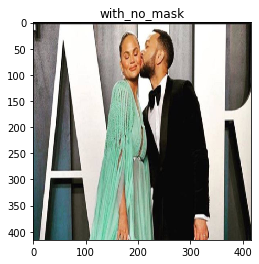

In [94]:
plt.imshow(preprocessing_xData[num])
plt.title(name[np.sum(preprocessing_yData[num,:,:,5])!=0])
plt.show()

In [99]:
test_image = preprocessing_xData[num:num+1].copy()

test_label = preprocessing_yData[num:num+1].copy()

In [100]:
test_image = test_image.astype('float32')
test_image = (2*test_image - 255)/255

In [101]:
result = object_model(test_image)

In [102]:
result.shape

TensorShape([1, 13, 13, 24])

In [103]:
name = ['confidence','bounding_x','bounding_y','bounding_w','bouding_h','class']

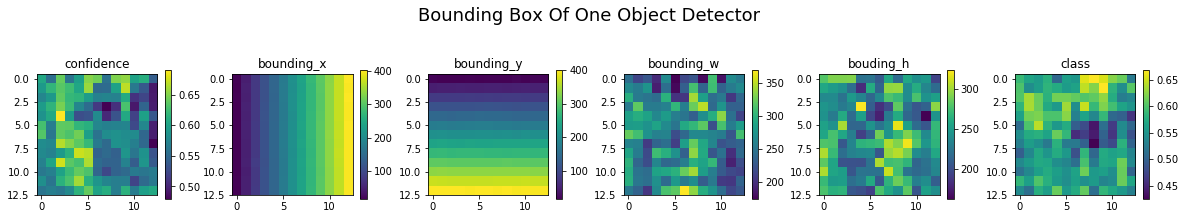

In [104]:
fig = plt.figure()           # Define "figure" instance
fig.set_size_inches(16,3)    # Physical page size in inches, (lx,ly)
suptit="Bounding Box Of One Object Detector"
fig.suptitle(suptit,fontsize=18,y=0.99)   # Title for the page
fig.subplots_adjust(left=0.02,right=1,bottom=0.1,top=0.7,wspace=0.3,hspace=0.3)

for i in range(6):
    ax = fig.add_subplot(1,6,i+1)
    pic1 = ax.imshow(result[:,:,:,i].numpy()[0])
    plt.title(name[i])
    plt.colorbar(pic1)
plt.show()

### LOSS

In [136]:
# IOU
def get_iou(y_truth, y_pred):
    """
    y_truth : shape=(:,13,13,6)
    y_pred  : shape=(:,13,13,6*4)
    """
    
    iou = []
    for i in range(4):
        # intersect
        intersect = (  K.minimum(y_truth,y_pred[:,:,:,i*6:6*i+6])[:,:,:,3:4]  *  K.minimum(y_truth,y_pred[:,:,:,i*6:6*i+6])[:,:,:,4:5]  )

        # union
        union = ((y_pred[:,:,:,i*6:6*i+6][:,:,:,3:4])*(y_pred[:,:,:,i*6:6*i+6][:,:,:,4:5]))  +  ((y_truth[:,:,:,3:4]) * (y_truth[:,:,:,4:5]))  -  (intersect)

        # iou
        iou.append(intersect/union)
        
    iou = K.concatenate(iou)
    
    
    return iou

In [137]:
y_true = test_label
y_pred = result

In [138]:
test_iou = get_iou(y_true,y_pred)

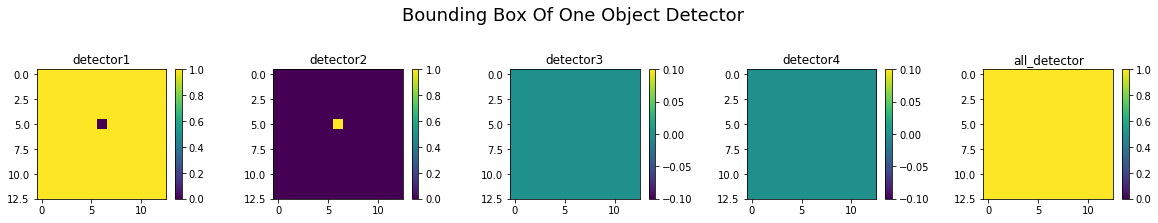

In [2113]:
fig = plt.figure()           # Define "figure" instance
fig.set_size_inches(16,3)    # Physical page size in inches, (lx,ly)
suptit="Bounding Box Of One Object Detector"
fig.suptitle(suptit,fontsize=18,y=0.99)   # Title for the page
fig.subplots_adjust(left=0.02,right=1,bottom=0.1,top=0.7,wspace=0.3,hspace=0.3)

name = ['detector1', 'detector2', 'detector3', 'detector4']

all_value = 0

for i in range(4):
    ax = fig.add_subplot(1,5,i+1)
    pic1 = ax.imshow(test_iou[0,:,:,i])
    plt.title(name[i])
    plt.colorbar(pic1)
    all_value += test_iou[0,:,:,i]
    
ax = fig.add_subplot(1,5,5)
pic1 = ax.imshow(all_value,vmin=0,vmax=1)
plt.title("all_detector")
plt.colorbar(pic1)
plt.show()

In [166]:
def custom_loss(y_true, y_pred):
    # y_true: shape=(:,13,13,6)
    # y_pred: shape=(:,13,13,6*4)
    
    lambda_coord = 5
    lambda_noobj = 0.05
    
    b = y_true.shape[0]
    print(b)
    
    
    iou = get_iou(y_true,y_pred)    # iou_one_hot    (:,13,13,4)
    
    objness_label = y_true[:,:,:,0] # confidence     (:,13,13,1)
    
    x_label = y_true[:,:,:,1]       # ground_truth_x (:,13,13,1)
    y_label = y_true[:,:,:,2]       # ground_truth_y (:,13,13,1)
    width_label = y_true[:,:,:,3]   # ground_truth_w (:,13,13,1)
    height_label = y_true[:,:,:,4]  # ground_truth_h (:,13,13,1)
    
    class_label = y_true[:,:,:,5]   # class          (:,13,13,1)
    
    
    total_loss = 0
    for i in range(4):
        # Bounding Box (:,13,13,1)
        obj_coord_loss = objness_label * (K.square(K.sqrt(x_label) - K.sqrt(y_pred[:,:,:,i*6+1])) + K.square(K.sqrt(y_label) - K.sqrt(y_pred[:,:,:,i*6+2]))) 
        obj_size_loss  = objness_label * K.sqrt(K.square(K.sqrt(width_label) - K.sqrt(y_pred[:,:,:,i*6+3])) + K.square(K.sqrt(height_label) - K.sqrt(y_pred[:,:,:,i*6+4]))) 
        
        # confidencev (:,13,13,1)
        objness_loss   = objness_label * K.square((iou[:,:,:,i] * objness_label)-y_pred[:,:,:,i*6+0])
        
        noobjness_loss = (1-objness_label) * K.square(objness_label-y_pred[:,:,:,i*6+0]) 
        
        # class (:,13,13,1)
        obj_class_loss = objness_label * K.square(class_label-y_pred[:,:,:,i*6+5])
        
        # sum
        obj_coord_loss = lambda_coord * K.sum(obj_coord_loss)
        print(obj_coord_loss)
        obj_size_loss  = lambda_coord * K.sum(obj_size_loss)
        print(obj_size_loss)
        objness_loss   = K.sum(objness_loss)
        print(objness_loss)
        noobjness_loss = lambda_noobj * K.sum(noobjness_loss)
        print(noobjness_loss)
        obj_class_loss = K.sum(obj_class_loss)
        print(obj_class_loss)
        total_loss += (obj_coord_loss + obj_size_loss + objness_loss + noobjness_loss + obj_class_loss)
        print("total:",total_loss)
        print("")
        
    total_loss /= b 
    
    return total_loss

In [167]:
y_true_k = K.variable(y_true)
y_pred_k = K.variable(y_pred)

In [168]:
custom_loss(y_true_k,y_pred_k)

1
tf.Tensor(8.806503, shape=(), dtype=float32)
tf.Tensor(110.0957, shape=(), dtype=float32)
tf.Tensor(0.5789608, shape=(), dtype=float32)
tf.Tensor(2.8644009, shape=(), dtype=float32)
tf.Tensor(0.7279128, shape=(), dtype=float32)
total: tf.Tensor(123.07349, shape=(), dtype=float32)

tf.Tensor(16.785564, shape=(), dtype=float32)
tf.Tensor(14.240346, shape=(), dtype=float32)
tf.Tensor(0.06021296, shape=(), dtype=float32)
tf.Tensor(2.5052023, shape=(), dtype=float32)
tf.Tensor(0.34302592, shape=(), dtype=float32)
total: tf.Tensor(157.00784, shape=(), dtype=float32)

tf.Tensor(6.395743, shape=(), dtype=float32)
tf.Tensor(38.168648, shape=(), dtype=float32)
tf.Tensor(0.07196849, shape=(), dtype=float32)
tf.Tensor(1.5396131, shape=(), dtype=float32)
tf.Tensor(0.5994423, shape=(), dtype=float32)
total: tf.Tensor(203.78326, shape=(), dtype=float32)

tf.Tensor(8.9619255, shape=(), dtype=float32)
tf.Tensor(157.41718, shape=(), dtype=float32)
tf.Tensor(0.28770673, shape=(), dtype=float32)
tf.Tens

<tf.Tensor: shape=(), dtype=float32, numpy=373.1076>

In [28]:
xTrain = (2*preprocessing_xData.astype('float32') - 255)/255

In [29]:
np.save('/Users/changmin.kim/Downloads/xTrain.npy',xTrain,allow_pickle=True)

In [198]:
# np.save('/Users/changmin.kim/Downloads/yTrain.npy',preprocessing_yData,allow_pickle=True)

array([-1.        , -0.99215686, -0.9843137 , -0.9764706 , -0.96862745,
       -0.9607843 , -0.9529412 , -0.94509804, -0.9372549 , -0.92941177,
       -0.92156863, -0.9137255 , -0.90588236, -0.8980392 , -0.8901961 ,
       -0.88235295, -0.8745098 , -0.8666667 , -0.85882354, -0.8509804 ,
       -0.84313726, -0.8352941 , -0.827451  , -0.81960785, -0.8117647 ,
       -0.8039216 , -0.79607844, -0.7882353 , -0.78039217, -0.77254903,
       -0.7647059 , -0.75686276, -0.7490196 , -0.7411765 , -0.73333335,
       -0.7254902 , -0.7176471 , -0.70980394, -0.7019608 , -0.69411767,
       -0.6862745 , -0.6784314 , -0.67058825, -0.6627451 , -0.654902  ,
       -0.64705884, -0.6392157 , -0.6313726 , -0.62352943, -0.6156863 ,
       -0.60784316, -0.6       , -0.5921569 , -0.58431375, -0.5764706 ,
       -0.5686275 , -0.56078434, -0.5529412 , -0.54509807, -0.5372549 ,
       -0.5294118 , -0.52156866, -0.5137255 , -0.5058824 , -0.49803922,
       -0.49019608, -0.48235294, -0.4745098 , -0.46666667, -0.45